<h2 style="color:#003f5b">Scrubbing Data Can Be Interesting</h2>

This post was originally going to focus on modeling hourly, regional electricity load data until I noticed that some of the series that I was importing from EIA appeared to be contaminated with outliers and missing data. I started scrubbing the data and I realized that it was actually kind of an intersting problem so I decided to turn the exercise into its own article. I know that this might not seem like the sexiest topic BUT I've managed to spice it up by using an unsupervised machine learning method to detect outliers.

<h2 style="color:#003f5b">Defining the Problem</h2>

The data in question is hourly load (MWs) from 6 different WECC Balancing Authorities. Each Balancing Authority will serve a region which will have its own unique load profile. Hourly load can fluctuate significantly depending on the day of the week, the time of day (peak or off-peak hours) and prevailing weather conditions. I wasn't really sure what parameters to use to define an outlier because there was so much variation within and between series. I wanted an efficient solution that could kind of be universally applied irregardless of the data I was working with. 

<h2 style="color:#003f5b">Creating the Soluation</h2>

When I was researching potential solutions I stumbled across this article: http://scikit-learn.org/stable/modules/outlier_detection.html from sci-kit learn which compares some of the different outlier detection methods that are available in the scikit-learn package. The Isolation Forrest method seemed like a good fit because of well rounded performance and computational efficiency.

The Isolation Forrest will be applied to 6 hourly load data series for each of the Balancing Authorities. Each hour, 1-24, will be input as a feature and the load in MW will be the value used for each feature to identify potenatial outliers. Hopefully the model will provide a short list of potential outlier values which can be used to quickly filter the data. Any missing values or omitted outliers can be replaced using an easy to employ intrepolation method.

<h2 style="color:#003f5b">Getting into the code</h2>

Let's start by declaring all of the package and script dependencies. We need pandas for working with dataframes and numpy for some array/matrix operations. Sklearn will used for running the Isolation Forrest algorithm and Matplotlib for graphing. Datetime is for some one-off datetime conversions. EIAPI is a script that we are importating based on my first jupyter article: https://nbviewer.jupyter.org/github/johnmrudolph/jupyter_blog/blob/master/working_with_apis.ipynb which shows how to pull EIA data using the EIA API. The EIAPI script can be found on my github here: https://github.com/johnmrudolph/jupyter_blog/blob/master/scripts/eiapi.py. Note that I made a few additions to the script from the EIA API jupyter article so that I could query the EIA API based on date ranges.

In [1]:
# required packages and scripts
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from datetime import datetime
# https://github.com/johnmrudolph/jupyter_blog/blob/master/scripts/eiapi.py
import eiapi as epi

# optional imports to run local and to set pandas display
import sys
sys.path.insert(0, '/home/johnr_000/jupyter_blog/jupyter_blog/scripts')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<h2 style="color:#003f5b">Creating the Datasets</h2>

To pull the hourly load data for each of the Balancing Authorities we can use the GetSeries class from the EIAPI script. This will return a pandas dataframe of dates and values for each series that we request. To use the GetSeries class a few parameters need to be specified. Required inputs are an API key and a series_id. I also specify optional paramters of a start date, end date and the frequency of the series so that we can query a specified date range. If you are dealing with hourly time series data then your datasets can get pretty large if you are not careful.

In [2]:
# can be obtained from EIA here: http://www.eia.gov/opendata/register.php
api_key = 'Your Api Key'
# start and end dates for beginning and end of time series
#  pulling data from Dec 2016 - Jan 2016
# must be in yyyy-mm-dd hh:mm:ss format if pulling hourly data
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
# must specify that frequency is hourly 'H' for datetime conversion
freq = 'H'

# create list of series_id used for dictionary keys
# going to pull 6 balancing authorities
# full list of available series is here: http://www.eia.gov/opendata/qb.php?category=2122628
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']

# create dict of GetSeriesRange objects from series list
series_dict = {key: epi.GetSeries(api_key=api_key, series_id=key, 
                                    start=start, end=end, freq=freq) for key in keys}

<h2 style="color:#003f5b">What Data Did We Just Get?</h2>

I didn't give a whole lot of detail above about what series specifically I was querying. The GetSeries class stores the json and subsets of the json to make it easier to get at some of the underlying data. I'm familiar with the format of the JSON returned from the EIA API so I know that I can pull out the ull name of the series by keying off the 'name' key which is nested several layers deep in the JSON. By the way here is some detail on EIA JSON formatting: http://www.eia.gov/opendata/commands.php.

In [3]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

Demand for PacifiCorp East (PACE), Hourly: EBA.PACE-ALL.D.H
Demand for PacifiCorp West (PACW), Hourly: EBA.PACW-ALL.D.H
Demand for Bonneville Power Administration (BPAT), Hourly: EBA.BPAT-ALL.D.H
Demand for Seattle City Light (SCL), Hourly: EBA.SCL-ALL.D.H
Demand for Puget Sound Energy, Inc. (PSEI), Hourly: EBA.PSEI-ALL.D.H
Demand for Portland General Electric Company (PGE), Hourly: EBA.PGE-ALL.D.H


OK so now we can see that we are pulling hourly load data for 6 different WECC Balancing Authorities: 
1. PacifiCorp East
2. PacifiCorp West
3. Bonneville Power Administration (BPA)
4. Seattle City Light
5. Puget Sound Energy
6. Potland General Electric

To make the data easier to work with I'm going to merge all the series into a single dataframe and I'm going to pickle the merged dataframe so that this data is available without having to cal the EIA API again. If you want to work with the data without having to do an API call then the pkl file can be found here" https://github.com/johnmrudolph/jupyter_blog/blob/master/data/nw_load_df.pkl.

In [ ]:
# merge dataframes from series_dict in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1)
# output merged dataframe as a pkl file
concat_df.to_pickle('data/nw_load_df.pkl')
# to read pkl back into a pandas df
# concat_df = pd.read_pickle('data/new_load_df.pkl')

<h2 style="color:#003f5b">Some Descriptive Statistics</h2>

We are reasonably confident that we are pulling something from EIA so lets try to take a look at the hourly load for each series. We can do this by looping over the dataframe and using the keys that we defined earlier when we called the EIA API using GetSeries. Each key will correspond with the underlying data values returned from the EIA API, which should be hourly load in MW. Pandas has built in functions to give us the mean, median, min and max for each variable in a dataframe.

In [6]:
# print out descriptive statistics for each series
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7059.477471418964 ' median :'7109.0 ' min :'5006 ' max :'9365
EBA.PACE-ALL.D.H '	
 mean :'-24706.174848688635 ' median :'5508.0 ' min :'-31990166 ' max :'59668
EBA.PACW-ALL.D.H '	
 mean :'4451.197713517148 ' median :'2709.0 ' min :'-6785 ' max :'2530003
EBA.PGE-ALL.D.H '	
 mean :'2579.9219905850705 ' median :'2646.0 ' min :'1730 ' max :'3472
EBA.PSEI-ALL.D.H '	
 mean :'3946.0661268556005 ' median :'4021.0 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1282.2589105581708 ' median :'1324.0 ' min :'868 ' max :'1654


We can make a few observations from this:
1. The median seems to give us the clearest picture of load for each series
2. PacifiCorp East (EBA.PACE-ALL.D.H) and PacifiCorp West (EBA.PACW-ALL.D.H) appear to have some wonky values

Negative values don't really make a whole lot of sense here. It shouldn't be possible for a balancing authority to have negative load so it is safe to assume that we can remove these from the dataset.

<h2 style="color:#003f5b">Filtering Out Negative Values</h2>

Let's loop through the dataframe and replace any negative values with NAs. Then we can use pandas to fill in the NAs using an interpolation.

In [ ]:
for key in keys:
    concat_df[concat_df[key] < 0] = np.nan

# keeping it simple by using a linear interpolation
concat_df = concat_df.interpolate(method='linear')

Let's output the descriptive statistics again to see if our negative values have been replaced with something more reasonable. This will come through in the min and the average.

In [7]:
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7057.380823767725 ' median :'7107.0 ' min :'5006.0 ' max :'9365.0
EBA.PACE-ALL.D.H '	
 mean :'5532.663065496286 ' median :'5508.0 ' min :'4108.0 ' max :'59668.0
EBA.PACW-ALL.D.H '	
 mean :'4478.549628629305 ' median :'2710.0 ' min :'1763.0 ' max :'2530003.0
EBA.PGE-ALL.D.H '	
 mean :'2578.5563808237675 ' median :'2643.0 ' min :'1730.0 ' max :'3472.0
EBA.PSEI-ALL.D.H '	
 mean :'3944.419376693767 ' median :'4017.5 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1281.6914247130317 ' median :'1322.0 ' min :'868.0 ' max :'1654.0


As expected the negative value problem has been corrected BUT PacifiCorp East and West have MAX values that look unreasonably large. Now I'm a bit stuck at how to proceed. I don't have a whole lot of confidence in this datset. I know that there are at least 2 values that are clearly incorrect BUT I don't really have a good feel about how much contamination there is in this dataset.

<h2 style="color:#003f5b">Predicting Outliers with an Isolation Forrest</h2>

I have a pretty solid understanding of most supervised machine learning methods however I will freely admit that I am not an expert at unsupervised machine learning. The reading material and examples provided by sklearn is pretty sparse but I was able to get a start by looking at this example: http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py. The detail documentation for the Isolation Forrest can be found here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html.

Using the Isolation Forrest is pretty straightforward. Set a few parameters on the Isolation Forrest model, then call the model to fit a set of values and related features. In this case the values are hourly load in MWs and we are only using hours (1-24) as a feature. Note that the model will be fit for each of the 6 Balancing Authorities separately. Ideally we would have clean training set to fit our model with but that isn't really an option here since we only have a contaiminated dataset.

We'll create a class called PredictOutliers to carry out 3 tasks:
1. Define the Isolation Forrest model
2. Fit the Isolation Forrest to the input data
3. Return a dataframe based on the Isolation Forrest predictions for each observation from the input data

In [8]:
class PredictOutliers(object):
    
    def __init__(self, input_data, label, col1, col2, cont, rand):
        '''
        :param input_data: a dataframe that contains the values and features to be fit
        :param label: name of series being fitted
        :param col1: the values which will be fitted by Isolation Forrest
        :param col2: the feature which will be fitted by Isolation Forrest
        :cont: the estimated contamination in the dataset between 0-1
        :rand: a random seed value to use for estimation
        '''
        # subset input dataframe based on col1 (values) and col2 (feature)
        self.training_data = pd.DataFrame(input_data.loc[:,[col1, col2]])
        # label and index will be used for the outlier prediction dataframe
        self.label = label
        self.index = input_data.index.values
        # fit Isolation Forrest and merge prediction with training dataframes
        self.pred_data = pd.concat([self.training_data, self.create_predictions()], axis=1)
    
    # (2)
    def fit_clf(self, cont, rand):
        '''
        :cont: the estimated contamination in the dataset between 0-1
        :rand: a random seed value to use for estimation
        '''
        clf = IsolationForest(contamination=cont, random_state=rand)
        return clf.fit(self.training_data.values)
    
    # (3)
    def create_predictions(self):
        # predicts whether observation is an outlier - returns a boolean
        opred = self.clf.predict(self.training_data.values)
        # returns the decision function used for outlier prediction
        # will be a decimal value - the more negative the more likely an outlier
        dfunc = self.clf.decision_function(self.training_data.values)
        # set dataframe labels for prediction and decision function
        l1 = '{}{}'.format(self.label, '_opred')
        l2 = '{}{}'.format(self.label, '_dfunc')
        # return a dataframe of prediction and decision function
        return pd.DataFrame(np.column_stack((opred, dfunc)), index=self.index, columns=[l1, l2])

The 3 main elements of the class are numbered separately:

(1) 

In [33]:
# Interpolate missing values and create hourly column from index
concat_df = concat_df.interpolate(method='linear')
concat_df.loc[:,'HOUR'] = pd.to_datetime(concat_df.index).hour
# Create a dictionary of predictions for each series
pred_dict = {key: PredictOutliers(concat_df, key, 'HOUR', key, .01, 1234) for key in keys}

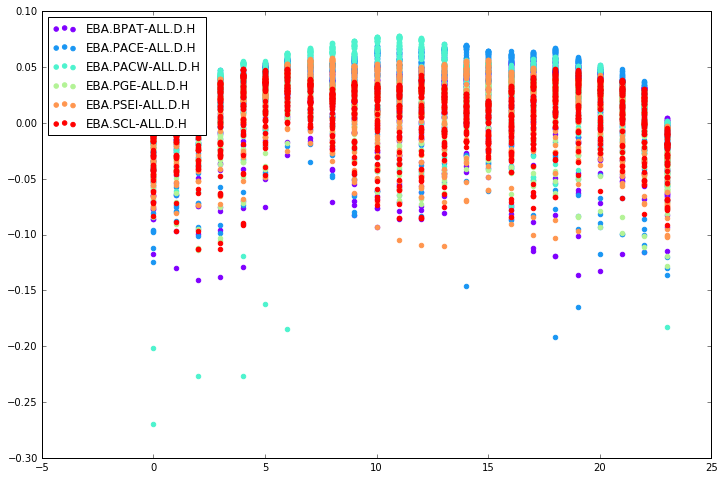

In [34]:
# Plot the decision function for each series
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    pred_data = pred_dict[key].pred_data
    plt.scatter(pred_data['HOUR'].values, pred_data['{}{}'.format(key, '_dfunc')].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()

In [35]:
# Output all observations that are predicted to be outliers
for key in keys:
    pred_df = pred_dict[key].pred_data
    print(key + ': \n',
          pred_df[pred_df[key + '_opred'] == -1][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
                      EBA.BPAT-ALL.D.H  EBA.BPAT-ALL.D.H_dfunc
2016-01-04 02:00:00          9267.000                  -0.141
2016-01-04 03:00:00          9152.000                  -0.138
2016-01-03 19:00:00          9266.000                  -0.137
2016-01-03 20:00:00          9148.000                  -0.133
2016-01-04 01:00:00          8981.000                  -0.130
2016-01-04 04:00:00          9004.000                  -0.129
2016-01-03 18:00:00          9365.000                  -0.119
2016-01-02 18:00:00          9298.000                  -0.119
2016-01-03 21:00:00          8971.000                  -0.117
2016-01-04 00:00:00          8656.000                  -0.117
2016-01-03 22:00:00          8807.000                  -0.115
2016-01-03 23:00:00          8628.000                  -0.115
2016-01-02 17:00:00          9284.000                  -0.114
2016-01-03 17:00:00          9256.000                  -0.112
2016-01-02 19:00:00          9016.000             

In [31]:
# create a function for filter our dataframes based on decision function values
def dfunc_filter(filter_list, pred_dict):
    for tup in filter_list:
        pred_data = pred_dict[tup[0]].pred_data
        pred_data.loc[pred_data[tup[0] + '_dfunc'] <= tup[1], tup[0]] = np.nan
        pred_data.loc[:,tup[0]] = pred_data.loc[:,tup[0]].interpolate(method='linear')
        print(pred_data[pred_data[tup[0] + '_dfunc'] <= 
                  tup[1]][[tup[0],tup[0] + '_dfunc']].sort_values(by = tup[0] + '_dfunc'))

In [36]:
# call function to apply filters
dfunc_filter([('EBA.PACE-ALL.D.H', -0.14), ('EBA.PACW-ALL.D.H', -0.16)], pred_dict)

                     EBA.PACE-ALL.D.H  EBA.PACE-ALL.D.H_dfunc
2015-12-22 18:00:00          5187.667                  -0.192
2015-12-22 19:00:00          5185.333                  -0.165
2016-01-05 14:00:00          5850.000                  -0.146
                     EBA.PACW-ALL.D.H  EBA.PACW-ALL.D.H_dfunc
2016-01-11 00:00:00          2604.000                  -0.270
2015-12-08 04:00:00          2734.500                  -0.227
2015-12-09 02:00:00          2666.000                  -0.227
2016-01-06 00:00:00          3039.667                  -0.202
2016-01-12 06:00:00          2671.000                  -0.185
2016-01-05 23:00:00          3013.333                  -0.183
2016-01-12 05:00:00          2802.000                  -0.162
2016-01-12 04:00:00          2933.000                  -0.119


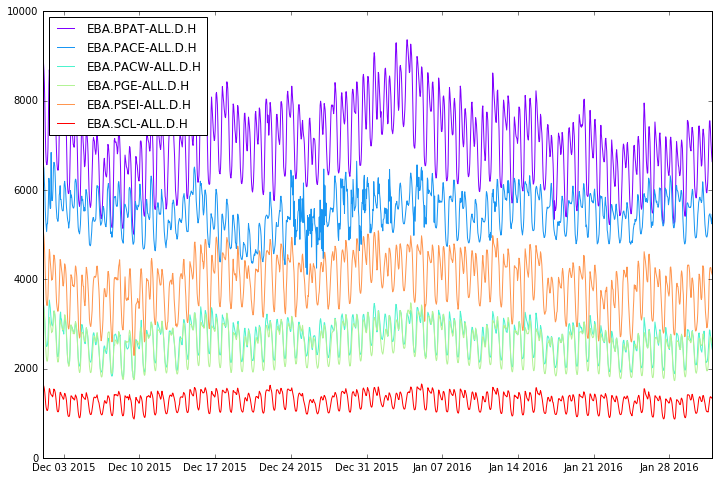

In [37]:
# Plot hourly load data
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    plt.plot(pd.to_datetime(pred_dict[key].pred_data.index), pred_dict[key].pred_data.loc[:,key].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()